13:26:31 - cmdstanpy - INFO - Chain [1] start processing
13:26:31 - cmdstanpy - INFO - Chain [1] done processing


MSE: 0.6699052665965538
MAE: 0.5657623574175423
RMSE: 0.8184774075052736
MAPE: 24.192355317287326


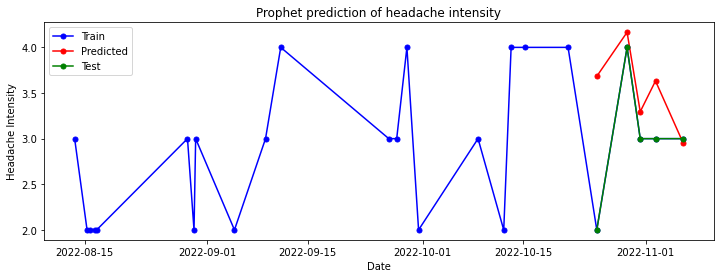

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Settings for accessing the API
BASE_URL = "YOUR URL HERE"
TOKEN = "YOUR TOKEN HERE"

headers = {
    "Authorization": f"Bearer {TOKEN}"
}


def fetch_data(endpoint):
    response = requests.get(f"{BASE_URL}{endpoint}", headers=headers)
    if response.status_code == 200:
        return pd.DataFrame(response.json())
    else:
        response.raise_for_status()

df = fetch_data("YOUR ENDPOINT HERE")
df = df.rename(columns={"_time": "ds"})
df['ds'] = pd.to_datetime(df['ds'], format="mixed").dt.tz_localize(None)
prophet_df = df[['ds', 'headache_intensity']].dropna()
prophet_df = prophet_df.rename(columns={"headache_intensity": "y"})

# Split the data into training and test sets (test set is the last 5 periods)
train_df = prophet_df[:-5]
test_df = prophet_df[-5:]

# Fit the Prophet model
m = Prophet()
m.fit(train_df)

# Make future dataframe for the next 5 periods
future = m.make_future_dataframe(periods=5)
forecast = m.predict(future)

test_forecast = forecast[-5:]

# Ensure indices align (MAPE doesn't work otherwise)
test_df = test_df.reset_index(drop=True)
test_forecast = test_forecast.reset_index(drop=True)

# Calculate and print MSE, MAE, RMSE, MAPE
mse= mean_squared_error(test_df['y'], test_forecast['yhat'])
mae = mean_absolute_error(test_df['y'], test_forecast['yhat'])
rmse = mean_squared_error(test_df['y'], test_forecast['yhat'], squared=False)
mape = np.mean(np.abs((test_df['y'] - test_forecast['yhat']) / test_df['y'])) * 100

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

# Convert to numpy arrays for plotting
full_ds = prophet_df['ds'].values
full_y = prophet_df['y'].values
test_ds = test_df['ds'].values
test_y = test_df['y'].values
predicted_yhat = test_forecast['yhat'].values

# Make plot
plt.figure(figsize=(12, 4))
plt.plot(full_ds, full_y, 'bo-', label='Train', markersize=5)
plt.plot(test_ds, predicted_yhat, 'ro-', label='Predicted', markersize=5)
plt.plot(test_ds, test_y, 'go-', label='Test', markersize=5)
plt.xlabel('Date')
plt.ylabel('Headache Intensity')
plt.title('Prophet prediction of headache intensity')
plt.legend()
plt.show()